### Sampling all terms
To check that revesible jump is giving me a consistent answer, I will look at the posterior of K_2 without using reversible jump. 

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
from torsionfit.toy_model import ToyModel
import torsionfit.backends.sqlite_plus as db
import torsionfit.plots as plots
from parmed.topologyobjects import DihedralType
from pymc import MCMC
from pymbar.timeseries import detectEquilibration
import numpy as np


Generate toy model that only allows 0 or 180 phases but allows all multiplicities to be on

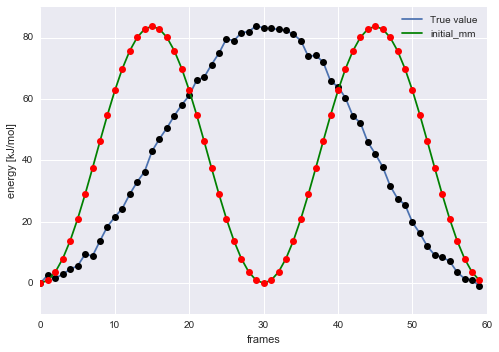

In [2]:
toy = ToyModel(true_value=DihedralType(10, 1, 180, 1, 1), initial_value=DihedralType(10, 2, 180, 1, 1),
               n_increments=30, sample_phase=True, rj=False)
plt.plot(toy.synthetic_energy, label='True value')
plt.plot(toy.synthetic_energy, 'ko')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
plt.plot(toy.scan_set.mm_energy, color='g', label='initial_mm')
plt.plot(toy.scan_set.initial_mm, 'ko', color='r')
plt.legend()

In [3]:
# sample
sampler = MCMC(toy.model.pymc_parameters, db=db, dbname='discrete_phase.sqlite')
sampler.sample(iter=10000)

 [-----------------100%-----------------] 10000 of 10000 complete in 567.9 sec

In [5]:
print('true value')
print(toy.true_value)
print('initial value')
print(toy.initial_value)
print('Fit value')
print(toy.model.pymc_parameters['CG331_CG321_CG321_CG331_1_K'].value)

true value
<DihedralTypes [<DihedralType; phi_k=10.000, per=1, phase=180.000,  scee=1.000, scnb=1.000>]>
initial value
<DihedralType; phi_k=10.000, per=2, phase=180.000,  scee=1.000, scnb=1.000>
Fit value
9.989739200590098


With discrete phase proposals torsionfit does not gives a good fit even if all labels are off. 

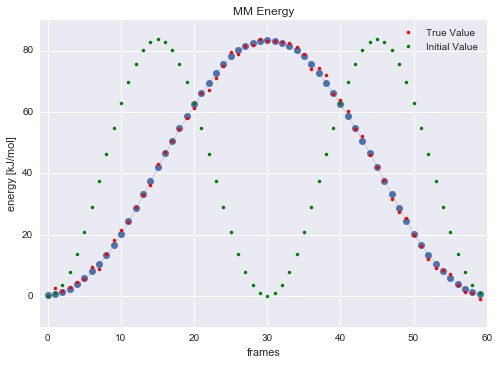

In [6]:
seaborn.tsplot(sampler.trace('mm_energy')[:], interpolate=False)
plt.plot(toy.synthetic_energy, '.', color='r', label='True Value')
plt.title('MM Energy')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
#plt.plot(sampler.trace('mm_energy')[0])
plt.plot(toy.scan_set.initial_mm, '.', color='g', label='Initial Value')
plt.legend()
plt.savefig('energy_fit_discrete.pdf')

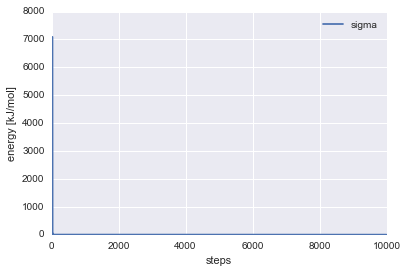

In [9]:
plt.plot(np.exp(sampler.trace('sigma')[:]), label='sigma')
plt.legend()
plt.xlabel('steps')
plt.ylabel('energy [kJ/mol]')
plt.savefig('sigma_discrete.pdf')

In [10]:
[t, g, N_eff] = detectEquilibration(sampler.trace('sigma')[:])
print('Start of equilibrated data: {}'.format(t))

Start of equilibrated data: 1063


In [11]:
print('true value')
print(toy.true_value)
print('initial value')
print(toy.initial_value)

true value
<DihedralTypes [<DihedralType; phi_k=10.000, per=1, phase=180.000,  scee=1.000, scnb=1.000>]>
initial value
<DihedralType; phi_k=10.000, per=2, phase=180.000,  scee=1.000, scnb=1.000>


From the traces of each parameters, you can see how the phases are stuck at 0 and most Ks are random. 

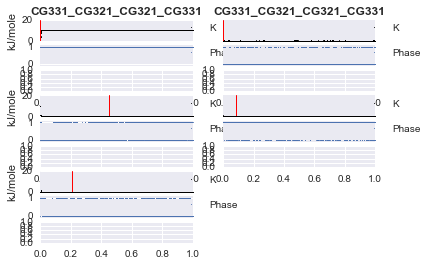

In [12]:
plots.trace_plots('CG331_CG321_CG321_CG331', sampler, markersize=2.0, filename='traces_discrete.pdf')

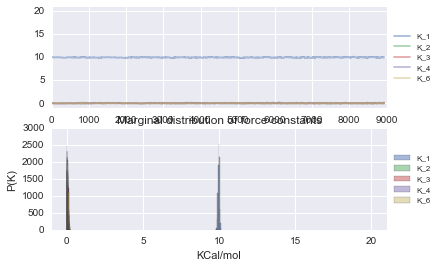

In [14]:
alpha = 0.5
plt.subplot(2, 1, 1)
plt.plot(sampler.CG331_CG321_CG321_CG331_1_K.trace[t:], label='K_1', alpha=alpha)
plt.plot(sampler.CG331_CG321_CG321_CG331_2_K.trace[t:], label='K_2', alpha=alpha)
plt.plot(sampler.CG331_CG321_CG321_CG331_3_K.trace[t:], label='K_3', alpha=alpha)
plt.plot(sampler.CG331_CG321_CG321_CG331_4_K.trace[t:], label='K_4', alpha=alpha)
plt.plot(sampler.CG331_CG321_CG321_CG331_6_K.trace[t:], label='K_6', alpha=alpha)
plt.ylim(-1, 21)
lgd = plt.legend(prop={'size': 8}, loc='center left', bbox_to_anchor=(1, 0.5))


plt.subplot(2, 1, 2)
plt.hist(sampler.CG331_CG321_CG321_CG331_1_K.trace[t:], label='K_1', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_2_K.trace[t:], label='K_2', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_3_K.trace[t:], label='K_3', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_4_K.trace[t:], label='K_4', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_6_K.trace[t:], label='K_6', alpha=alpha)
plt.xlim(-1, 21)



lgd = plt.legend(prop={'size': 8}, loc='center left', bbox_to_anchor=(1, 0.5))


plt.title('Marginal distribution of force constants')
plt.xlabel('KCal/mol')
plt.ylabel('P(K)')
plt.savefig('trac_hist.pdf')

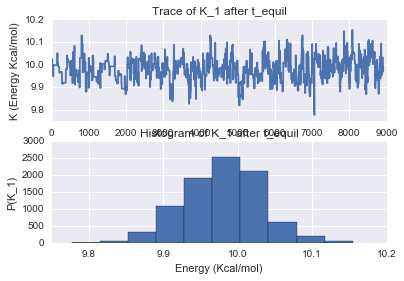

In [18]:
plt.subplot(2, 1, 1)
plt.title('Trace of K_1 after t_equil')
plt.plot(sampler.CG331_CG321_CG321_CG331_1_K.trace[t+20:])
plt.xlabel('samples')
plt.ylabel('K (Energy Kcal/mol)')
plt.subplot(2, 1, 2)
plt.title('Histogram of K_1 after t_equil')
plt.hist(sampler.CG331_CG321_CG321_CG331_1_K.trace[t+20:], label='K_1')
plt.xlabel('Energy (Kcal/mol)')
plt.ylabel('P(K_1)')
plt.savefig('trace_hist_label_on.pdf')

Posterior of K_2 looks very close to reversible jump. 

In [19]:
mean = np.mean(sampler.CG331_CG321_CG321_CG331_1_K.trace[t:])
variance = np.var(sampler.CG331_CG321_CG321_CG331_1_K.trace[t:])

In [21]:
print('Mean and variance for K_1')
print('Mean: {}'.format(mean))
print('Variance: {}'.format(variance))

Mean and variance for K_1
Mean: 9.979942977844916
Variance: 0.0026200046861537007
